In [1]:
#steps 
#2.image difference
#3.analysis 
import os
import matplotlib.pyplot as plt
import cv2
import glob
import numpy as np
import quaternion
import tqdm
import bispy as bsp

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
Data= 'CD_DNN/*/*.bmp'

In [4]:
# Data= '/content/drive/My Drive/CD_DNN/*/*.bmp'

In [5]:
Images=[]
Names = []
for name in glob.glob(Data):
  Images= Images + [cv2.imread(name,cv2.IMREAD_GRAYSCALE)]
  Names = Names +[name]
  print(name)

CD_DNN\Bern-SAR\changed_map.bmp
CD_DNN\Bern-SAR\difference_image.bmp
CD_DNN\Bern-SAR\im1.bmp
CD_DNN\Bern-SAR\im2.bmp
CD_DNN\Bern-SAR\im3.bmp
CD_DNN\Mexico_City-optical\changed_map.bmp
CD_DNN\Mexico_City-optical\difference_image.bmp
CD_DNN\Mexico_City-optical\im1.bmp
CD_DNN\Mexico_City-optical\im2.bmp
CD_DNN\Mexico_City-optical\im3.bmp
CD_DNN\Muragia-optical\im1.bmp
CD_DNN\Muragia-optical\im2.bmp
CD_DNN\Muragia-optical\im3.bmp
CD_DNN\Ottawa-SAR\changed_map.bmp
CD_DNN\Ottawa-SAR\difference_image.bmp
CD_DNN\Ottawa-SAR\im1.bmp
CD_DNN\Ottawa-SAR\im2.bmp
CD_DNN\Ottawa-SAR\im3.bmp
CD_DNN\Yellow River I-SAR\im1.bmp
CD_DNN\Yellow River I-SAR\im2.bmp
CD_DNN\Yellow River I-SAR\rf.bmp
CD_DNN\Yellow River II-SAR\im1.bmp
CD_DNN\Yellow River II-SAR\im2.bmp
CD_DNN\Yellow River II-SAR\im3.bmp
CD_DNN\Yellow River III-SAR\im1.bmp
CD_DNN\Yellow River III-SAR\im2.bmp
CD_DNN\Yellow River III-SAR\reference黄河3.bmp
CD_DNN\Yellow River IV-SAR\im1.bmp
CD_DNN\Yellow River IV-SAR\im2.bmp
CD_DNN\Yellow River IV-SAR

In [32]:
print(Images[0].shape)

(301, 301)


In [6]:
# for i in range(len(Images)):
#   plt.figure()
#   plt.imshow(Images[i],cmap = 'gray')
#   plt.title("{}".format(i)+Names[i])

In [7]:
plt.rcParams['figure.figsize'] = [4, 4] 

Text(0.5, 1.0, 'Second Image')

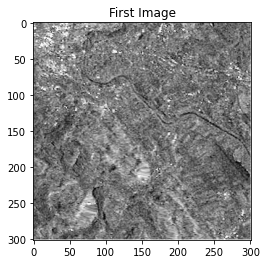

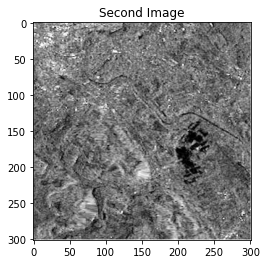

In [8]:
img1 = Images[2]
img2 = Images[3]

plt.imshow(img1,cmap = 'gray')
plt.title("First Image")
plt.figure()
plt.imshow(img2,cmap = 'gray')
plt.title("Second Image")

Text(0.5, 1.0, 'Log Difference Image')

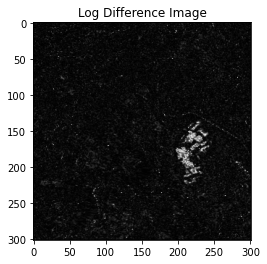

In [9]:
#the output below is the normal log difference
a = np.double(img1) + 1
b = np.double(img2) + 1

log_diff =np.abs(np.log(np.divide(b,a)))
# log_diff =np.uint8(np.abs(np.log(np.divide(b,a))))

# log_diff = log_diff*(255/np.max(log_diff))

plt.imshow(log_diff,cmap = 'gray')
plt.title('Log Difference Image')

# cv2.imshow('Log Difference Image',log_diff)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [10]:
r = log_diff/3
g = log_diff/3
b = log_diff/3

I = (r+g+b)/3
R = r-(g+b)/2;
G = g-(r+b)/2;
B = b-(r+g)/2;
Y = (r+g)/2 - np.abs(r-g)/2 -b;
Y[Y<0] = 0
RG = np.double(R - G)
BY = np.double(B - Y)

In [11]:
temp = np.stack((RG,BY,I,np.zeros(I.shape)),axis = -1)
Q = quaternion.as_quat_array(temp)

In [12]:
Q.shape

(301, 301)

In [13]:
Q_fft = bsp.qfft.Qfft(Q)

In [33]:
A = np.abs(Q_fft)
Phase = Q_fft/A

A=np.log(1+np.fft.fftshift(A))

k = 15
k2 = 15

Ak = cv2.GaussianBlur(A, (k,k),cv2.BORDER_REFLECT)
Ak= np.exp(np.fft.ifftshift(Ak))-1
FL_Filtered = Ak*Phase
FIL = bsp.qfft.iQfft(FL_Filtered)
FIL = np.square(np.abs(FIL))

FIL_smoothened = cv2.GaussianBlur(FIL, (k2,k2),cv2.BORDER_REFLECT)

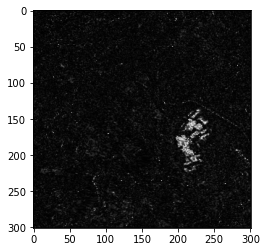

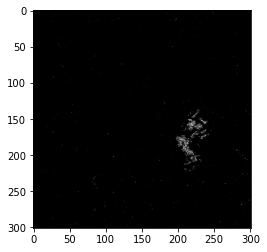

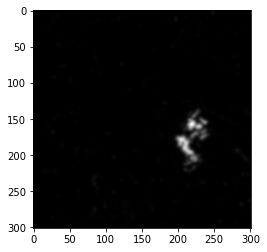

In [34]:
size = (8,8)
plt.figure()#figsize=size)
plt.imshow(log_diff,'gray')
plt.figure()#figsize=size)
plt.imshow(FIL,'gray')
plt.figure()#figsize=size)
plt.imshow(FIL_smoothened,'gray')

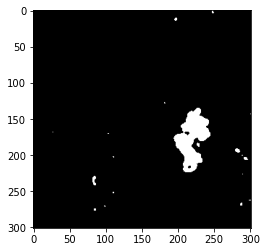

In [79]:
# Generate Change Candidates using Thresholding
t = 0.05
Change_candidates = FIL_smoothened.copy()
Change_candidates[Change_candidates>=t] = 1
Change_candidates[Change_candidates<t] = 0

plt.figure()#figsize=size)
plt.imshow(Change_candidates,'gray')

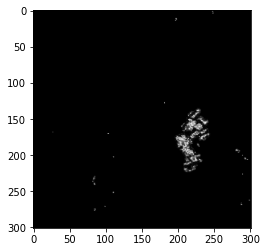

In [80]:
Candidates = Change_candidates*log_diff
plt.imshow(Candidates,'gray')

[0 1 2]


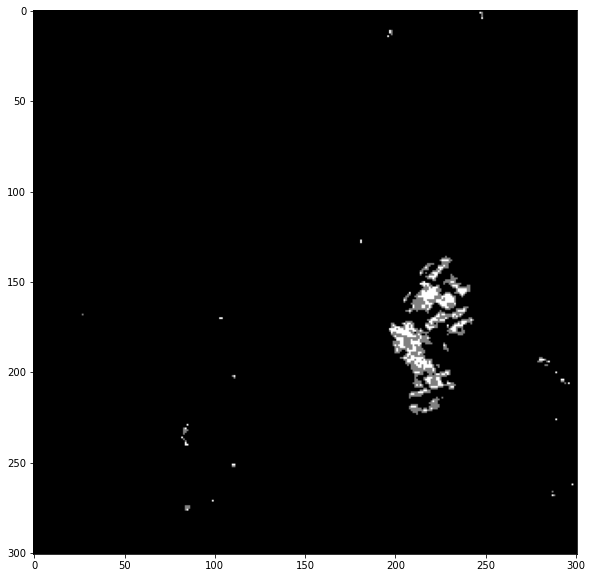

In [81]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(Candidates.flatten().reshape(-1, 1))

plt.figure(figsize = (10,10))
Labeled = kmeans.labels_
plt.imshow(Labeled.reshape(Candidates.shape),'gray')
print(np.unique(Labeled))

In [82]:
# from fcmeans import FCM
# fcm = FCM(n_clusters=3)
# fcm.fit(Candidates.flatten().reshape(-1, 1))

# plt.figure(figsize = (10,10))
# Labeled = fcm.predict(Candidates.flatten().reshape(-1, 1))
# plt.imshow(Labeled.reshape(Candidates.shape),'gray')
# print(np.unique(Labeled))

# Patch Extraction

In [65]:
#Pad Image
Padded1 = np.zeros((img1.shape[0]+2,img1.shape[1]+2))
Padded1[1:-1,1:-1] = img1

Padded2 = np.zeros((img2.shape[0]+2,img2.shape[1]+2))
Padded2[1:-1,1:-1] = img2

#Extract Patches
Patches1 = []
Patches2 = []
for i in tqdm.tqdm(range(img1.shape[0])):
    for j in range(img1.shape[1]):
        Patches1 = Patches1 + [Padded1[i:i+3,j:j+3].flatten()]
        Patches2 = Patches2 + [Padded2[i:i+3,j:j+3].flatten()]

100%|██████████| 301/301 [02:58<00:00,  1.69it/s]


In [66]:
Patches1 = np.array(Patches1)
Patches2 = np.array(Patches2)
print(Patches1.shape,Patches2.shape)

(90601, 9) (90601, 9)


In [67]:
Combined_Patches  = np.concatenate((Patches1,Patches2),axis = 1)
print(Combined_Patches.shape)

(90601, 18)


In [68]:
# # Label such that 0 is for unknown
# CorrectLabels = Labeled + 1
# CorrectLabels[CorrectLabels == 3] = 0
# plt.figure(figsize = (8,8))
# plt.imshow(CorrectLabels.reshape(img1.shape),'gray')

In [69]:
# import myssl
# agr = myssl.SSLSolver()
# predlabels,_,_ = agr.fit(Combined_Patches, CorrectLabels, 100, 20,tuning_param = 10)
# Prediction = predlabels.reshape(img1.shape)
# plt.figure(figsize = (8,8))
# plt.imshow(Prediction, 'gray')

In [83]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,max_iter=2500,penalty = 'l2').fit(Combined_Patches[np.logical_or(Labeled==0,Labeled==1)], Labeled[np.logical_or(Labeled==0,Labeled==1)])
prediction = clf.predict(Combined_Patches)
output = Labeled.copy()
output[output == 2] = prediction[output == 2]

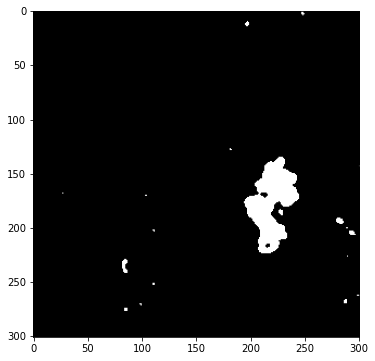

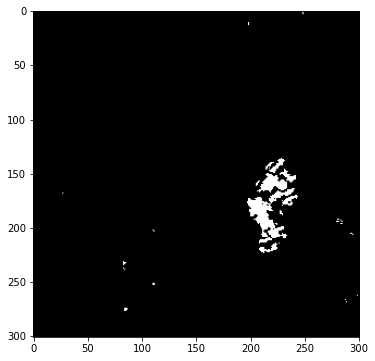

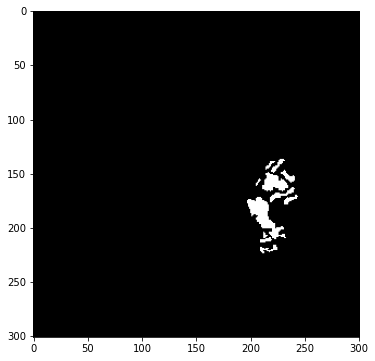

In [105]:
result = output.reshape(img1.shape)
GroundTruth = Images[4]*255
size = (6,6)
plt.figure(figsize = size)
plt.imshow(Change_candidates,'gray')

plt.figure(figsize = size)
plt.imshow(result,'gray')

plt.figure(figsize = size)
plt.imshow(GroundTruth,'gray')

In [135]:
def OveralError(im1,im2):
    diff = np.abs(im1-im2)
    result = np.sum(diff)
    return result

def PCC(im1,im2):
    OE = OveralError(im1,im2)
    tot = im1.shape[0]*im1.shape[1]
    result = ((tot - OE)/tot)*100
    return result

def Kappa(im1,im2):
    tot = im1.shape[0]*im1.shape[1]
    TP = np.sum(np.logical_and(im1 == 1, im2 == 1))/tot
    FP = np.sum(np.logical_and(im1 == 0, im2 == 1))/tot
    TN = np.sum(np.logical_and(im1 == 0, im2 == 0))/tot
    FN = np.sum(np.logical_and(im1 == 1, im2 == 0))/tot
    
    
    pre = ((TP+FP)*(TP+FN) + (FN+TN)*(FP+TN))
    pcc = PCC(im1,im2)/100
    result = (pcc-pre)/(1-pre) *100
    return (result)

In [136]:
print(OveralError(result,GroundTruth),PCC(result,GroundTruth),Kappa(result,GroundTruth))

378 99.582786061964 84.60888424136277


In [96]:
result.shape[0]*result.shape[1]

90601